# ESA CCI Biomass V5.01 — Access and Visualization (Token-secured)

Authors: Rajat Shinde (UAH), Alex Mandel (Development Seed), Sheyenne Kirkland (UAH), Harshini Girish (UAH), Jamison French (Development Seed), Henry Rodman (Development Seed), Chuck Daniels (Development Seed), Zac Deziel (Development Seed), Brian Freitag (NASA)

Date: August 27, 2025

Description: This notebook documents how to access and visualize the ESA CCI Biomass V5.01 dataset hosted on the ESA MAAP server. It is an example illustrating data access from ESA server based on ESA MAAP Token using the NASA MAAP Authorization.

---

## What you will do
1. Understand the product and file organization.  
2. Obtain an ESA access token.  
3. Access a V5.01 raster using the token.  
4. Visualize in Python.  

---

## Run this notebook
To access and run this tutorial within MAAP’s Algorithm Development Environment (ADE), please refer to the “Getting started with the MAAP” section of our documentation.

Disclaimer: it is highly recommended to run a tutorial within MAAP’s ADE, which already includes packages specific to MAAP, such as maap-py. Running the tutorial outside of the MAAP ADE may lead to errors.  

**Prerequisites**  
- An active ESA MAAP portal account with access initialized.  
- OAuth2 client credentials for your ESA realm.  
- Python packages: `requests`, `rasterio`, `numpy`, `matplotlib` (optional: `pystac-client`, `stackstac`).  


## Importing and Installing Packages

In [15]:
# Install if needed. Comment out if already available.
# !mamba install -y -c conda-forge rasterio xarray matplotlib fsspec requests
# !pip install pystac-client stackstac

import os
import requests
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from pystac_client import Client
from rasterio.merge import merge
import numpy.ma as ma
from rasterio.plot import show
import os, stat, getpass, pathlib


plt.rcParams["figure.figsize"] = (6, 6)
plt.rcParams["axes.grid"] = False

## Getting the Token from the ESA MAAP portal

This explains how to retrieve a short-lived access token from the ESA MAAP portal using your browser and NASA EDL login.

Open the token page in your browser:
**https://portal.maap.eo.esa.int/ini/services/auth/token/**

**Steps**
1. Navigate to the URL above.  
2. Choose **NASA Earthdata Login (EDL)** when prompted and authorize access.  
3. After successful authorization you will see a **token page** showing your short‑lived access token string.

**The below screenshots illustrate the process for each steps.**
- **Portal entry page**:  
  ![Portal](./images/esa_maap.jpg)
- **NASA EDL authorization screen**:  
  ![NASA EDL](./images/page2.jpg)
- **Token page after authorization**:  
  ![Token Page](./images/page3.jpg)

**Copy the token value** from the token page for use in the next cell.

**Notes**
- Tokens are short‑lived. If you see **401 Unauthorized** later, refresh the token using the same URL and update the value in the notebook.
- Treat tokens as secrets. Do not commit them to version control or share publicly.

Now we paste the token we got from the portal and save it to a file so it can be used later in the notebook.

In [16]:
TOKEN_FILE = pathlib.Path.home() / ".config" / "esa_maap" / "token"
TOKEN_FILE.parent.mkdir(parents=True, exist_ok=True)

if not TOKEN_FILE.exists():
    tok = getpass.getpass("Paste ESA portal token (hidden): ").strip()
    if not tok:
        raise ValueError("Empty token.")
    TOKEN_FILE.write_text(tok, encoding="utf-8")
    # owner read/write only: 0o600
    TOKEN_FILE.chmod(stat.S_IRUSR | stat.S_IWUSR)

# Verify permissions are 600
st = TOKEN_FILE.stat()
if (st.st_mode & 0o777) != 0o600:
    raise PermissionError(f"{TOKEN_FILE} must have mode 600. Fix with: chmod 600 {TOKEN_FILE}")

ESA_TOKEN = TOKEN_FILE.read_text(encoding="utf-8").strip()
print("Token loaded from file:", TOKEN_FILE)


Token loaded from file: /projects/.config/esa_maap/token


## Discover tiles via ESA STAC

Now, we will query the ESA STAC API for CCIBiomassV5.01 over the given bbox and year, then we will extract GeoTIFF asset URLs from returned items.

In [17]:
STAC_URL = "https://catalog.maap.eo.esa.int/catalogue/"
COLLECTION = "CCIBiomassV5.01"
BBOX = [10.0, 0.0, 10.6, 0.6]               
DT = "2010-01-01/2010-12-31"

In [18]:
api   = Client.open(STAC_URL)
items = list(api.search(collections="CCIBiomassV5.01", bbox=BBOX, datetime=DT).get_items())
hrefs = []
for it in items:
    for a in it.assets.values():
        if (a.media_type and "geotiff" in a.media_type.lower()) or a.href.lower().endswith(".tif"):
            hrefs.append(a.href)
assert hrefs, "No GeoTIFF assets found for AOI/year."

## Creating a Mosaic

Open the selected COG tiles with token-auth, then merge them within the AOI (BBOX) to build a single mosaic. Record the nodata value from the first source and close all datasets to free handles.

In [19]:
with rio.Env(GDAL_HTTP_HEADERS=f"Authorization: Bearer {ESA_TOKEN}",
             GDAL_DISABLE_READDIR_ON_OPEN="EMPTY_DIR", GDAL_NUM_THREADS="ALL_CPUS"):
    srcs = [rio.open(h) for h in hrefs]
    mosaic, out_transform = merge(srcs, bounds=BBOX)   # mosaic: (bands, y, x)
    nodata = srcs[0].nodatavals[0]
    for s in srcs: s.close()

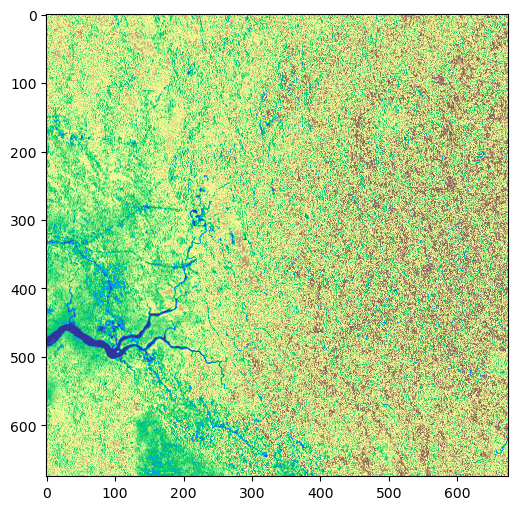

<Axes: >

In [20]:
masked = ma.masked_values(mosaic, int(nodata) if nodata is not None else -9999)
show(masked, cmap="terrain")

## Saving Tile as COG

Finally, we can save the tile as COG locally. 

In [12]:
# Save COG
out_cog = "cci_biomass_v5_mosaic_cog.tif"
profile = dict(driver="COG", dtype=mosaic.dtype.name, count=mosaic.shape[0],
               height=mosaic.shape[1], width=mosaic.shape[2],
               crs="EPSG:4326", transform=out_transform)
cog_opts = dict(BLOCKSIZE="512", COMPRESS="LZW", OVERVIEWS="AUTO",
                NUM_THREADS="ALL_CPUS", RESAMPLING="NEAREST")
with rio.open(out_cog, "w", **profile, **cog_opts) as dst:
    dst.write(mosaic)

# Validate COG
with rio.open(out_cog) as ds:
    print(dict(driver=ds.driver, tiled=ds.profile.get("tiled"),
               block=(ds.profile.get("blockxsize"), ds.profile.get("blockysize")),
               compress=ds.profile.get("compress"), overviews=ds.overviews(1)))


{'driver': 'GTiff', 'tiled': True, 'block': (512, 512), 'compress': 'lzw', 'overviews': [2]}


In [2]:
# Replace with a tile you are authorized to access.
# This is an example pattern for a 2010 tile. Adjust path/year/tile as needed.
V5_EXAMPLE_URL = (
    "https://catalog.maap.eo.esa.int/"
    "data/biomass-maap-01/CCIBiomassV5.01/2010/01/01/"
    "N00E010_ESACCI-BIOMASS-L4-AGB-MERGED-100m-2010-fv5.0/"
    "N00E010_ESACCI-BIOMASS-L4-AGB-MERGED-100m-2010-fv5.0.tif"
)

print(V5_EXAMPLE_URL)

https://catalog.maap.eo.esa.int/data/biomass-maap-01/CCIBiomassV5.01/2010/01/01/N00E010_ESACCI-BIOMASS-L4-AGB-MERGED-100m-2010-fv5.0/N00E010_ESACCI-BIOMASS-L4-AGB-MERGED-100m-2010-fv5.0.tif


Here we make a request to the example tile using the token to check that authentication is working.

In [6]:
headers = {"Authorization": f"Bearer {ESA_TOKEN}"}
r = requests.get(V5_EXAMPLE_URL, headers=headers, stream=True)

print("HTTP status:", r.status_code)
if r.status_code == 403:
    print(
        "403 Forbidden: Your account may need initialization for this collection.\n"
        "Follow any initialization link provided by the server, refresh the token, and retry."
    )
elif r.status_code == 401:
    print("401 Unauthorized: Token expired or invalid. Get a new token at the portal URL and update ESA_TOKEN.")
elif r.status_code != 200:
    print("Unexpected status. Check URL, permissions, or try another tile/year.")
else:
    print("Access OK.")


HTTP status: 200
Access OK.


Shape: (11250, 11250)
CRS: EPSG:4326
Transform: | 0.00, 0.00, 10.00|
| 0.00,-0.00, 0.00|
| 0.00, 0.00, 1.00|
Min/Max: 0.0 852.0


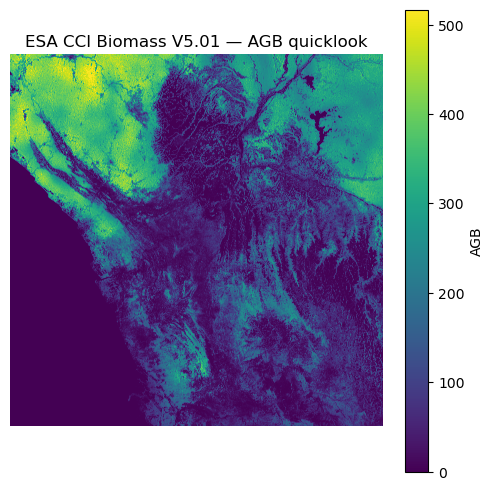

In [7]:
if r.status_code == 200:
    with MemoryFile(r.content) as mem:
        with mem.open() as ds:
            arr = ds.read(1)  # first band
            prof = ds.profile

    valid = arr[np.isfinite(arr)]
    if valid.size == 0:
        raise RuntimeError("No valid pixels found in the selected asset.")

    print("Shape:", arr.shape)
    print("CRS:", prof.get("crs"))
    print("Transform:", prof.get("transform"))
    print("Min/Max:", float(np.nanmin(valid)), float(np.nanmax(valid)))

    plt.imshow(arr, vmin=np.nanpercentile(valid, 2), vmax=np.nanpercentile(valid, 98))
    plt.title("ESA CCI Biomass V5.01 — AGB quicklook")
    plt.colorbar(label="AGB")
    plt.axis("off")


The example CCI V5 tile is succesfully downloaded locally. 